@Author: Ben Funk

**Overview of Code**
This Python code is aimed at performing statistical analysis and modeling on a dataset with the goal of predicting a target variable, in this case, 'Target PPM'. The data set is imported from a CSV file named 'BenSummaryJustMatrix.csv'. This dataset consists of features including 'Resistance', 'Ratio', 'RelativeHumidity', 'Temperature', and the target variable 'Target PPM'.

**Initial Setup and Data Preprocessing**
The necessary libraries, including numpy, pandas, scipy, matplotlib, and sklearn, are first imported. Then, the dataset is loaded, and the different features along with the target variable are separated into different variables for easier processing.

Next, the code splits the data into training and testing sets using sklearn's train_test_split function. It also generates a scatter plot of 'Resistance' against 'Target PPM', with the color of the data points representing 'RelativeHumidity'.

**Custom Function Fitting and Evaluation**
The code defines two custom functions (funct3 and funct) with different mathematical forms, aiming to model the relationship between the features ('Resistance', 'RelativeHumidity', 'Temperature') and the target variable.

These functions are then fitted to the data using scipy.optimize.curve_fit, which performs a non-linear least squares optimization to find the best-fitting parameters. The Root Mean Squared Error (RMSE) is then calculated to quantify the model performance.

For each target PPM value, the 95% confidence interval is also computed using the scipy.stats.t.interval function, and the results are printed.

**Residual Analysis and Goodness-of-Fit Evaluation**
Finally, the code performs residual analysis and checks the goodness-of-fit of the models:

R-Squared: It calculates the R-squared value to quantify the proportion of the variance in the dependent variable that is predictable from the independent variables.

Q-Q Plot: The quantile-quantile (Q-Q) plot is generated using statsmodels.api.qqplot to check the normality of the residuals.

Residual vs. Predicted Plot: This plot is used to visualize potential heteroscedasticity in the residuals.

F-Statistic and P-Value: The F-statistic and its associated p-value are computed to test the overall significance of the model.

This entire process is repeated for both custom functions (funct3 and funct). The code output provides a comprehensive understanding of how well the models fit the data and can predict 'Target PPM' from the given features.

Before running this code, make sure the required libraries are installed and the dataset file ('BenSummaryJustMatrix.csv') is available in the specified directory ('Output/').

In [54]:
# Relevant libraries
import pandas as pd
import scipy.optimize as sc
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
from scipy.optimize import OptimizeWarning
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings


In [55]:
# Load data from CSV file
file2 = pd.read_csv("../Output/With low Data .csv")
# Extract the columns from the data
#file2=file2[file2['Target PPM']<=500]

#file2=file2[file2['Target PPM']!=150]
#file2=file2[file2['Target PPM']!=50]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

#calculate abso.lute humidity in g/m^3
P_actual_hPa = .8 * 1013.25
e_sat_standard = 6.112 * np.exp((17.67 * xDataTemp) / (xDataTemp + 243.5))
e_sat_actual = e_sat_standard * (P_actual_hPa / 1013.25)
xDataAH = 1000*((xDataRH/100)*e_sat_actual)/(461.5*(xDataTemp+ 273.15))

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


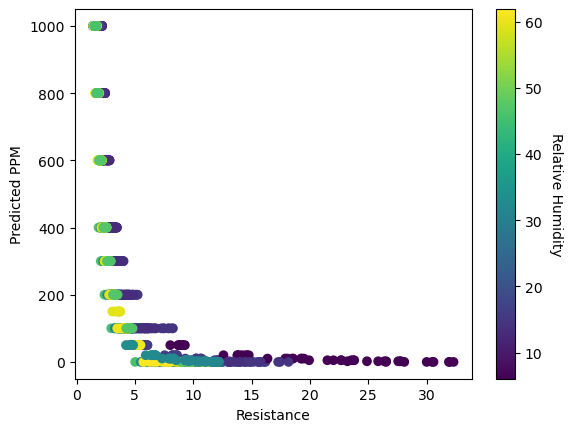

In [56]:
df = file2
# code to show data with relative humidity
scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity', rotation=270, labelpad=15)
plt.show()


# code to show data with absolute humidity
# scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataAH)
# plt.xlabel("Resistance")
# plt.ylabel('Predicted PPM')
# cbar = plt.colorbar(scatter)
# cbar.set_label('absolute', rotation=270, labelpad=15)
# plt.show()

/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_30273/3791995403.py:20: RuntimeWarning: invalid value encountered in power
  stuff=a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_30273/3791995403.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_30273/3791995403.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

[   0.96829309   -0.36012353   -8.84990439    0.3947806  -251.22855835
   18.37340204]
66.85191810939791


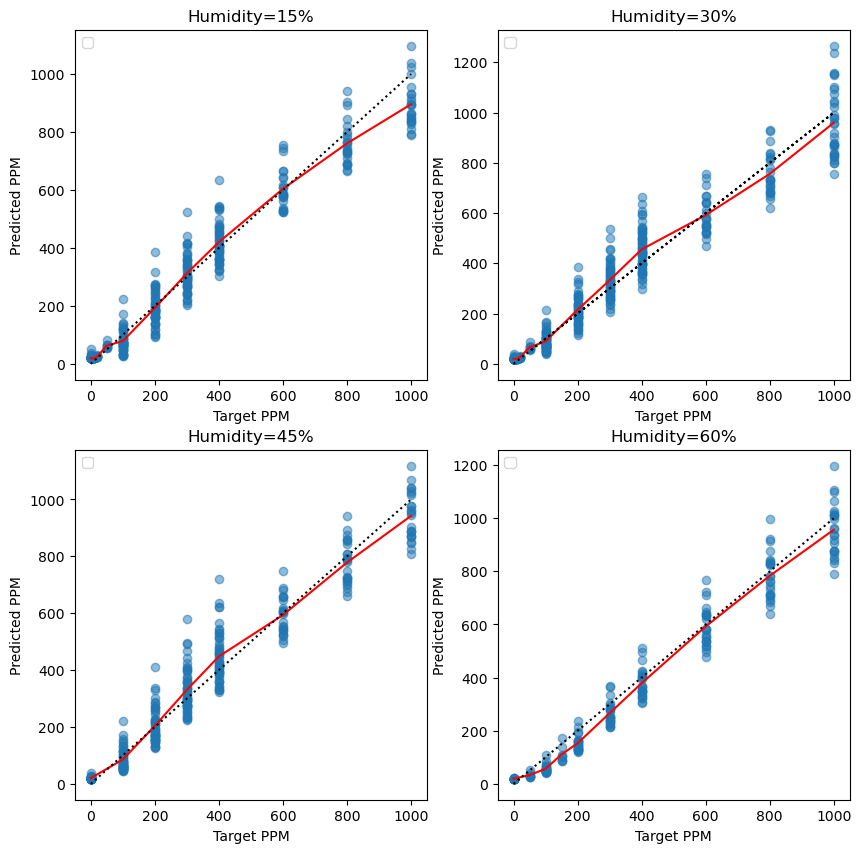

In [57]:
# Funk Equation
# a*R+b
# a*np.exp(-1*R*b+c)+d
# a*R**b+c
# a*R**b+c*H*(a*R**b+c)+d  (Basically Bastviken)
# (a*np.exp(-1*R*b+c)+d)+f*H*(a*np.exp(-1*R*b+c)+d)+g
# a*np.exp(-1*R*b+c)+d*np.exp(-1*H*f+g)+h (Funk Equation)
# a*np.exp((-1*R*b+c)+(-1*H*f+g))+h 4.2
#                                                           W/1000  W/500   UV500   UV1000
# a**((-1*R*b+c)+(-1*H*d+e))+f 6.4                          87.79   42.64   62.74   116.35
# a**((-1*R*b)+(-1*H*c)+d)+e   6.5                          87.79

# a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f 7.1                 74.09   35.76   62.37   113.46



def funkEQ(X, a, b,c,d,e,f):
    R, H = X
    with np.errstate(over='ignore'):
        stuff=a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f
    return stuff
p0 = 1, 1, 1, 1, 1,1

def residual(params, X, y):
    return np.sum((y - funkEQ(X, *params))**2)

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000

popt, pcov = sc.curve_fit(funkEQ, (xDataResistance, xDataRH), yDataTargetPPM, p0, maxfev=1000000)

# Print the optimized parameters as [a b c d e f]
print(popt)

#########
# Getting RMSE of Equation
#########

R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funkEQ((R_test, H_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

#########
# All the code needed to display predicted vs actual graphs
#########

from scipy.stats import t

# Degrees of freedom
df = len(yDataTargetPPM) - len(popt)

# Student's t value for the 95% confidence level
t_val = t.ppf(1-0.05/2, df)

# Compute the standard error of the parameters
perr = np.sqrt(np.diag(pcov))

# Compute the standard error of the predictions
def predict_std(X, popt, perr):
    jac = np.array([funkEQ(X, *popt[:i], 1 if j == i else 0, *popt[i+1:]) for i,j in enumerate(range(len(popt)))]).T
    return np.sqrt(np.sum((jac * perr) ** 2, axis=1))

# Compute the 95% confidence intervals for the predicted values
predict_std_val = predict_std((R_test, H_test), popt, perr)
conf_int_lower = y_pred - t_val * predict_std_val
conf_int_upper = y_pred + t_val * predict_std_val

# break up the points by humidity percentage to show more accurate graphs
humidity_values = [int(h) for h in [15,30,45,60]]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots

# Flatten the axs array in case it's 2D
axs = axs.flatten()

for i, H in enumerate(humidity_values):
    # Filter the data for the given humidity value
    mask = (file2['RelativeHumidity'] >= H-5) & (file2['RelativeHumidity'] <= H+5)
    df_filtered = file2.loc[mask]

    xDataResistance1 = df_filtered.loc[:, 'Resistance']
    xDataRH1 = df_filtered.loc[:, 'RelativeHumidity']
    yDataTargetPPM1 = df_filtered.loc[:, 'Target PPM']

    y_pred = funkEQ((xDataResistance1, xDataRH1), *popt)
    df_filtered['Predicted PPM'] = y_pred

    # Create a scatter plot
    sc = axs[i].scatter(yDataTargetPPM1, y_pred, alpha=.5)

    # Calculate mean prediction for each target PPM and plot it
    mean_pred_per_target_ppm = df_filtered.groupby('Target PPM')['Predicted PPM'].mean()
    axs[i].plot(mean_pred_per_target_ppm.index, mean_pred_per_target_ppm.values, color='r')

    # Add a linear dotted line
    axs[i].plot(yDataTargetPPM1, yDataTargetPPM1, 'k:')

    axs[i].legend()
    axs[i].set_xlabel('Target PPM')
    axs[i].set_ylabel('Predicted PPM')
    axs[i].set_title(f'Humidity={H}%')

plt.show()


In [60]:
# Calculate residuals using the training data
residuals = yDataTargetPPM - funkEQ((xDataResistance, xDataRH), *popt)
residuals_std = np.std(residuals)

# Calculate prediction
prediction = funkEQ([40,5], *popt)

# Calculate the 95% prediction interval
prediction_interval = 1.96 * residuals_std

print("Prediction:", prediction)
print("95% Prediction Interval: [", prediction - prediction_interval, ",", prediction + prediction_interval, "]")


Prediction: 18.37340704636971
95% Prediction Interval: [ -114.68305648021168 , 151.4298705729511 ]


R-squared:  0.9501914217331396


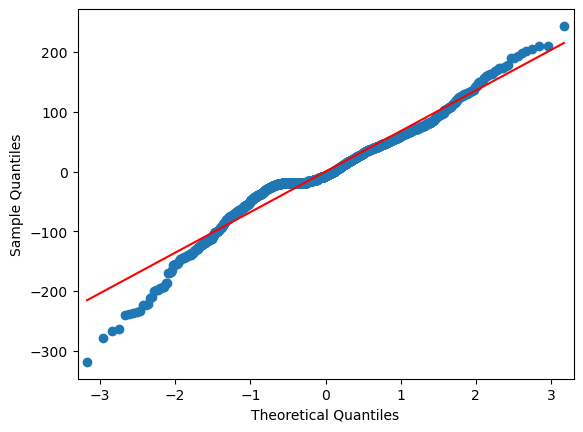

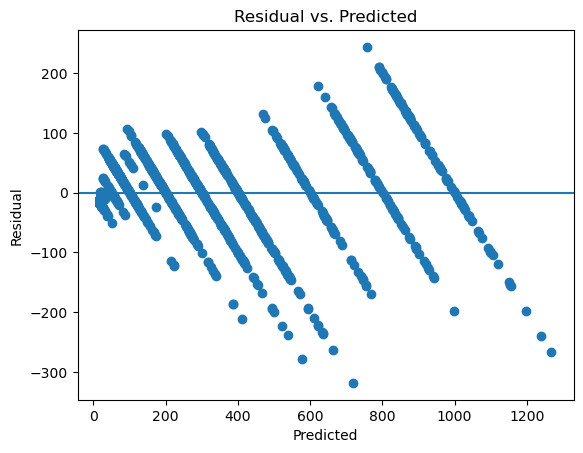

F-statistic: 5013.399585380481
p-value: 0.0


In [61]:
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = funkEQ((xDataResistance, xDataRH), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


In [ ]:
# Ignore all warnings in the code
warnings.filterwarnings("ignore")

def funkEQ(X, a, b,c,d,e,f):
    R, H = X
    with np.errstate(over='ignore'):
        stuff=a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f
    return stuff

def optimize_parameters(p0):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            warnings.filterwarnings('ignore', category=OptimizeWarning)

            popt, pcov = curve_fit(funkEQ, (xDataResistance, xDataRH), yDataTargetPPM, p0=p0, maxfev=1000000)

        return (p0, popt, np.sum((yDataTargetPPM - funkEQ((xDataResistance, xDataRH), *popt))**2))
    except Exception as e:
        print(f"Error with parameters {p0}: {str(e)}")
        return None

# Set the random seed for reproducibility
np.random.seed(42)

# Number of points to generate
num_points = 100000

initial_params = np.random.randint(-2, 2, size=(num_points, 6))

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(optimize_parameters)(p) for p in tqdm(initial_params))

# Filter out None, NaN, and Infinity results
successful_results = [result for result in results
                      if result is not None
                      and not np.any(np.isnan(result[1]))
                      and not np.any(np.isinf(result[1]))]

init_params, fitted_params, residuals = zip(*successful_results)

# Rank the parameters by their residual and only keep the top 10
best_params = np.array(fitted_params)[np.argsort(residuals)[:10]]
best_init = np.array(init_params)[np.argsort(residuals)[:10]]

# The best parameters are the first in the sorted list
#print('Fitted function parameters: a=%.3f, b=%.3f, c=%.3f d=%.3f, f=%.3f, g=%.3f' % (best_params[0][0], best_params[0][1], best_params[0][2], best_params[0][3], best_params[0][4], best_params[0][5]))

print('The initial conditions to get this optimization were: '+str(best_init[0]))

# Calculate RMSE for the best parameters
popt=best_params[0]
#best_params[0]=[18,  1,  4, 12,  0,  4, -7]
# file2=file2[file2["SensorID"]==3]
# X = file2.drop('Target PPM', axis='columns')
# y = file2.loc[:, 'Target PPM']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']
#popt = [38.538220,0.843161,4.637493,380.116483,0.06614,0.298036,-78.340227]
#popt = best_params[0]
# Generate the predictions using the optimized parameters and the input data
y_pred = funkEQ((R_test, H_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):

    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funkEQ((df.loc[:, 'Resistance'], df.loc[:, 'RelativeHumidity']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(0.95, len(myData)-1, loc=np.mean(myData), scale=st.sem(myData))


    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")


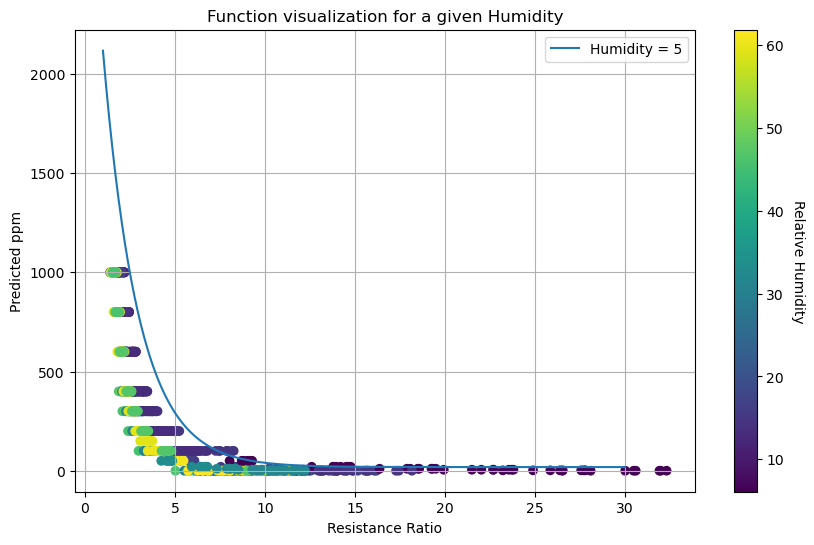

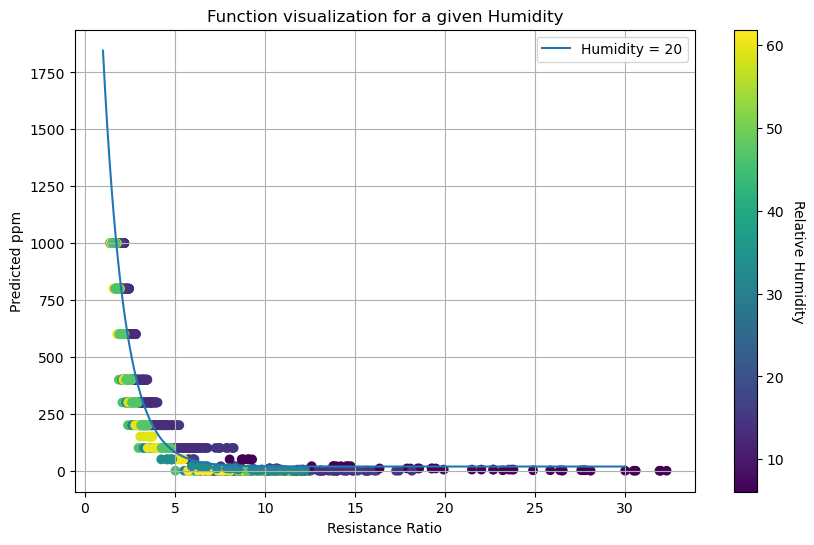

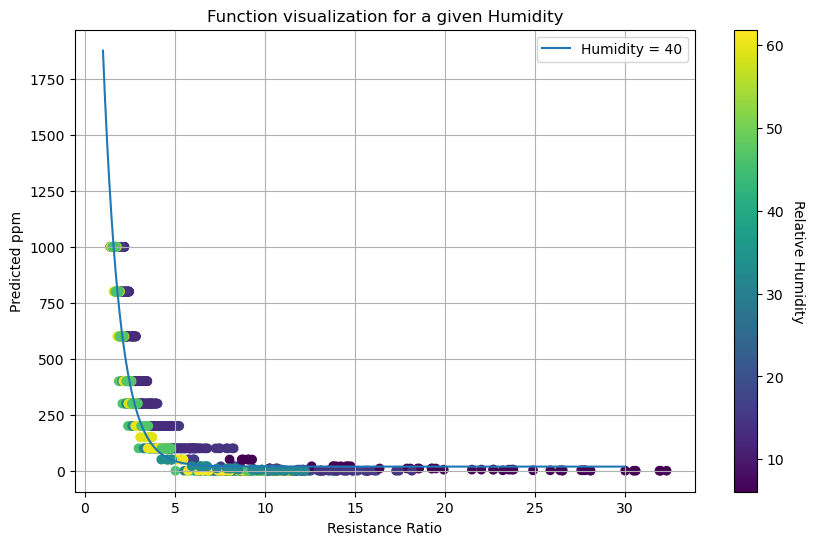

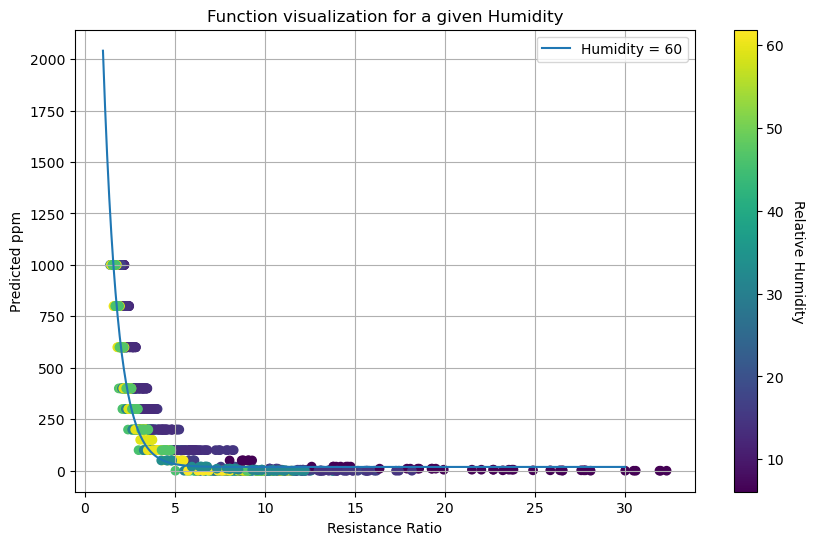

In [62]:
df=file2
# Define colors based on 'RelativeHumidity' column
colors = df.loc[:, 'RelativeHumidity']
R = np.linspace(1, 30, num=500)
for H in [5,20,40,60]:
    # calculate function values
    y_values = [funkEQ((r, H), *popt) for r in R]

    # plotting
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=colors, cmap='viridis')
    plt.plot(R, y_values, label=f'Humidity = {H}')
    plt.xlabel('Resistance Ratio')
    plt.ylabel('Predicted ppm')
    plt.title('Function visualization for a given Humidity')
    plt.legend()
    plt.grid(True)

    # Create colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Relative Humidity', rotation=270, labelpad=15)

    plt.show()


<Figure size 1000x800 with 0 Axes>

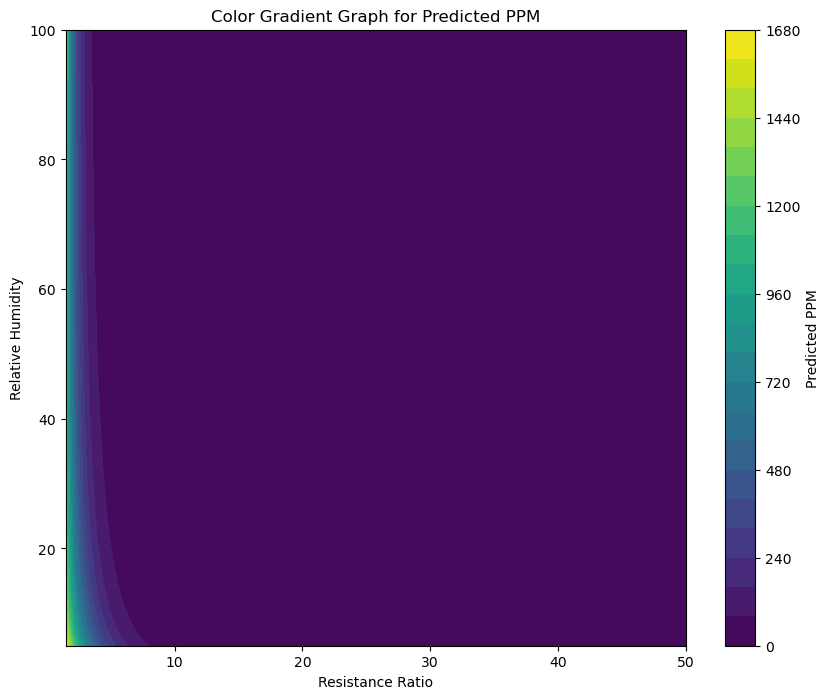

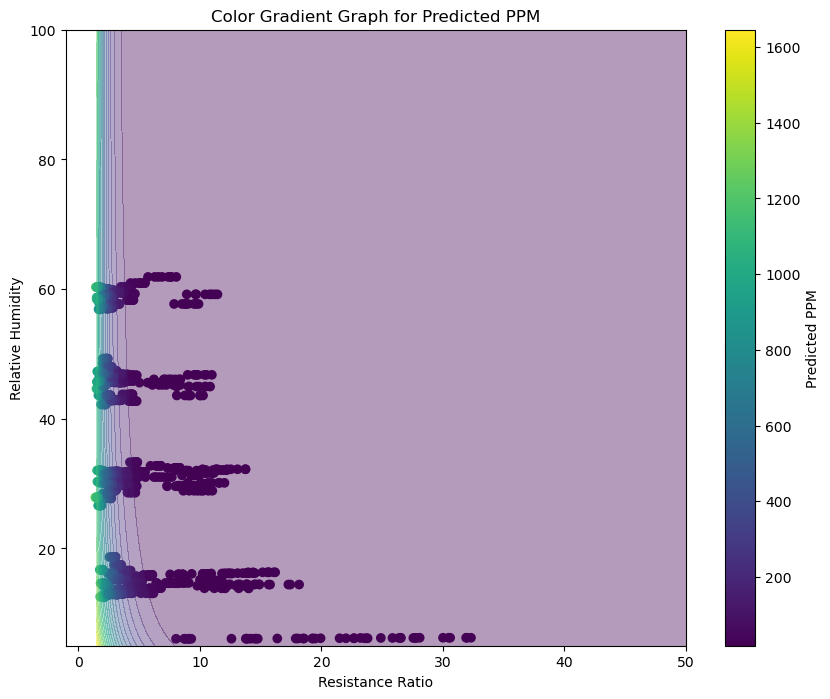

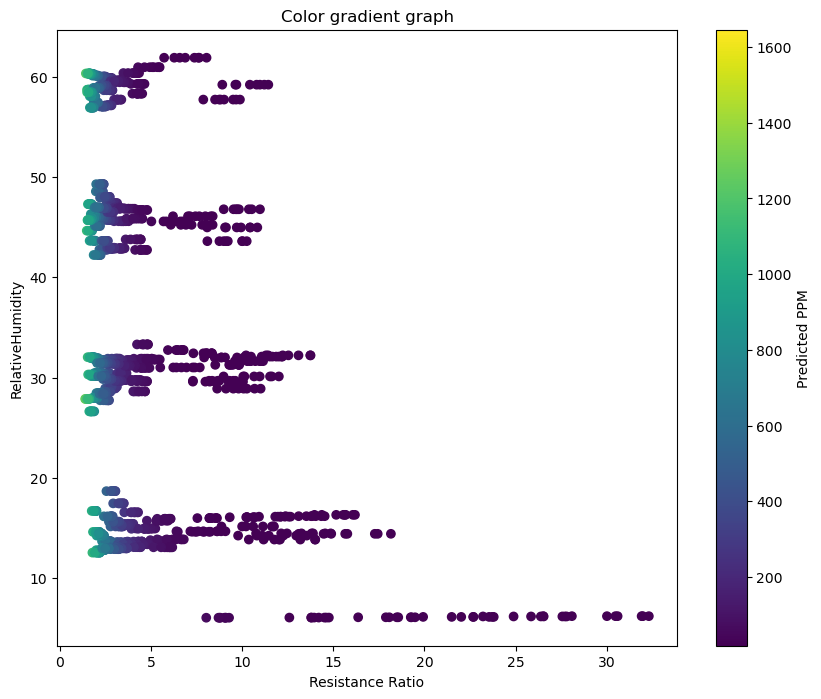

In [63]:
plt.figure(figsize=(10,8))
# Create a scatter plot, with the color determined by y_pred

resistance_range = np.linspace(1.5, 50, 1000)  # 10000 points between 0 and 1000
rh_range = np.linspace(5, 100, 1000)  # 10000 points between 0 and 100

# Create a grid of Resistance and RelativeHumidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)


# Compute predicted PPM for all combinations of Resistance and RelativeHumidity
pred_ppm = funkEQ((resistance_values, rh_values), *popt)

plt.figure(figsize=(10, 8))

# Generate a large number of levels for smoother color transitions
num_levels = 20
plt.contourf(resistance_values, rh_values, pred_ppm, num_levels, cmap='viridis')

plt.colorbar(label='Predicted PPM')
plt.xlabel('Resistance Ratio')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')
plt.show()
# Create a figure
plt.figure(figsize=(10,8))

# Get min and max values of y_pred and pred_ppm
vmin = min(y_pred.min(), pred_ppm.min())
vmax = max(y_pred.max(), pred_ppm.max())

# Draw the scatter plot with vmin and vmax
sc = plt.scatter(xDataResistance, xDataRH, c=y_pred, cmap='viridis', vmin=vmin, vmax=vmax)

# Compute predicted PPM for all combinations of Resistance and RelativeHumidity
pred_ppm = funkEQ((resistance_values, rh_values), *popt)

# Draw the contour plot with vmin and vmax
plt.contourf(resistance_values, rh_values, pred_ppm, num_levels, cmap='viridis', alpha=0.4, vmin=vmin, vmax=vmax)

# Create a colorbar
plt.colorbar(sc, label='Predicted PPM')

# Label axes and title
plt.xlabel('Resistance Ratio')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')

# Show the plot
plt.show()

plt.figure(figsize=(10, 8))
sc = plt.scatter(xDataResistance, xDataRH, c=y_pred, cmap='viridis', vmin=vmin, vmax=vmax)
# Create a colorbar
plt.colorbar(sc, label='Predicted PPM')
plt.xlabel('Resistance Ratio')
plt.ylabel('RelativeHumidity')
plt.title('Color gradient graph')
plt.show()


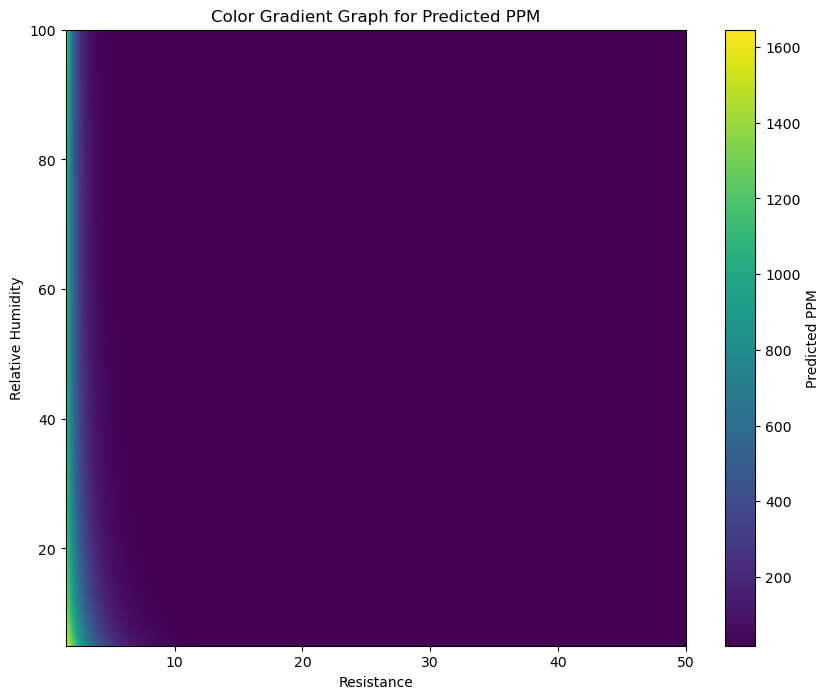

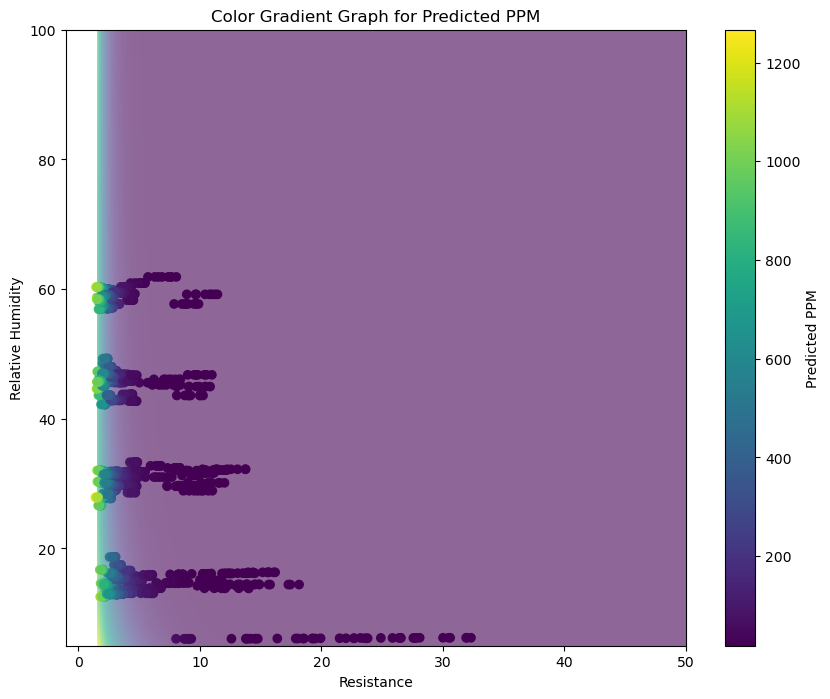

In [64]:


# Create a grid of Resistance and RelativeHumidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)


# Compute predicted PPM for all combinations of Resistance and RelativeHumidity
pred_ppm = funkEQ((resistance_values, rh_values), *popt)

plt.figure(figsize=(10, 8))

plt.imshow(pred_ppm, origin='lower', extent=[resistance_values.min(), resistance_values.max(), rh_values.min(), rh_values.max()], aspect='auto', cmap='viridis')

plt.colorbar(label='Predicted PPM')
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')
plt.show()
# Create a figure
plt.figure(figsize=(10, 8))

# Create a smooth color gradient with imshow() and set its opacity to 50%
plt.imshow(pred_ppm, origin='lower', extent=[resistance_values.min(), resistance_values.max(), rh_values.min(), rh_values.max()], aspect='auto', cmap='viridis', alpha=0.6)

# Add a scatter plot on top of the color gradient with 100% opacity
sc = plt.scatter(xDataResistance, xDataRH, c=y_pred, cmap='viridis', alpha=1.0)

plt.colorbar(label='Predicted PPM')
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')

plt.show()

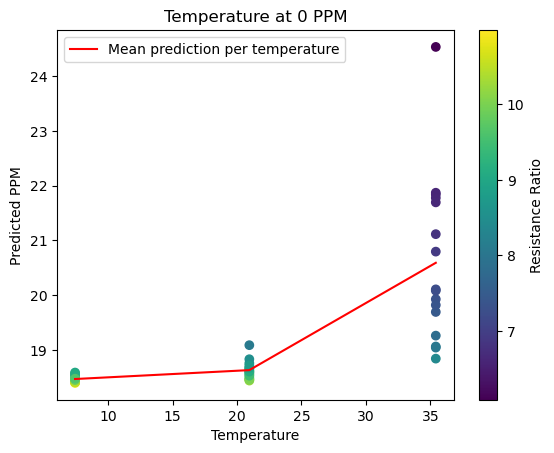

In [65]:
# adds function to view predicted ppm across temperatures while holding ppm and humidity constant
import matplotlib.cm as cm

file2 = pd.read_csv("/Users/benfunk/DataspellProjects/MethaneDataScience/Output/BenSummaryJustMatrix.csv")
file2=file2[file2["Target PPM"]<=0]
file2=file2[file2["RelativeHumidity"]<=50]
file2=file2[file2["RelativeHumidity"]>=40]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

df = file2
y_pred = funkEQ((xDataResistance, xDataRH), *popt)
df['Predicted PPM'] = y_pred
# Create a scatter plot with colorbar
sc = plt.scatter(df.loc[:, "Temperature"],y_pred, c=xDataResistance, cmap=cm.viridis)
plt.colorbar(sc, label='Resistance Ratio')
plt.xlabel("Temperature")
plt.ylabel('Predicted PPM')

# Calculate mean prediction for each temperature and plot it
mean_pred_per_temp = df.groupby('Temperature')['Predicted PPM'].mean()
plt.plot(mean_pred_per_temp.index, mean_pred_per_temp.values, color='r', label='Mean prediction per temperature')
plt.legend()
plt.title('Temperature at 0 PPM')

plt.show()

In [ ]:
# Define a range of humidity values

